# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import math
import json
import re

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.svm import SVC

% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
# lets check out few records in the portfolio df
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio.shape

(10, 6)

**Based on the data in the portfolia data set:**
  - Channels variable is multi-label (can split using MultiLabelBinarizer)
  - Rename 'id' variable to 'offer_id'
  - One Hot Encode the 'offer_type' variable
  
There are only 10 records.

In [10]:
# Lets create a new df with the Channels data split into binary values 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
binarizer_obj = MultiLabelBinarizer()
binarizer_obj.fit(portfolio['channels'])

offer_channels_df = pd.DataFrame(binarizer_obj.transform(portfolio['channels']),columns=binarizer_obj.classes_)

offer_channels_df

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [6]:
# Lets raneme the id variable to "offer_id"
portfolio.rename(columns={"id": "offer_id"}, inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [11]:
#Lets one hot encode the offert_type column
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
offer_type_df = pd.get_dummies(portfolio['offer_type'])
offer_type_df.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [12]:
#lets concantenate all the data frames together to create a new df
portfolio = pd.concat([portfolio, offer_type_df, offer_channels_df], axis=1)

# remove duplicate columns
#portfolio.drop(columns=['offer_type', 'channels'], inplace=True)

portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [13]:
# lets re-order the columns

portfolio_df = portfolio[ ['offer_id','difficulty','duration','reward','offer_type','bogo','discount',
                         'informational','channels','email','mobile','social','web'] ]

portfolio_df.head()

,offer_id,difficulty,duration,reward,offer_type,bogo,discount,informational,channels,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,bogo,1,0,0,"[email, mobile, social]",1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,bogo,1,0,0,"[web, email, mobile, social]",1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,informational,0,0,1,"[web, email, mobile]",1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,bogo,1,0,0,"[web, email, mobile]",1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,discount,0,1,0,"[web, email]",1,0,0,1


#### Profile Data

Lets take a look at the profile and perform EDA

In [14]:
# lets check out some data in the profile df
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile.shape

(17000, 5)

In [16]:
# Interesting to see rows with age as 118. Lets take a look at those
age_outlier_df = profile[profile.age == 118]

In [17]:
print("Unique Gender Values : ",age_outlier_df.gender.nunique())
print("Unique Age Values : ",age_outlier_df.age.nunique())
print("Unique income Values : ",age_outlier_df.income.nunique())

Unique Gender Values :  0
Unique Age Values :  1
Unique income Values :  0


### Outlier values in Profile Data Frame

  - There are many records with age value as 118
  - On closer examination you will notice that these records have no gender and income values
  - My assumption is that Date of Birth is not a mandatory field in the app. And anyone who doesnt have an age is given a default age by the app.

##### I am keeping this data in a separate data frame and removing these values from the profile data frame

In [18]:
age_outlier_df.shape

(2175, 5)

In [19]:
# remove the records with age values of 118. This should give us a total of 14825 records
profile = profile[profile.age < 118]

In [20]:
profile.shape

(14825, 5)

#### Lets do the following for the profile data
  - Change the date format of the became_member_on column
  - Lets get the year from the date. A new column "membershipstart" will be added
  - Lets hot encode the membership years
  - Lets create an age range from the ages column
  - Lets hot encode the age range values
  - Lets one hot encode the gender column
  - rename the id column to customer_id
  - remove any null values

In [21]:
# The date when the customer became a member is in YYYYMMDD format. Lets convert into a date format
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [22]:
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [23]:
profile['membershipstart'] = profile['became_member_on'].apply(lambda x: x.year)
profile.head()

,age,became_member_on,gender,id,income,membershipstart
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


In [24]:
# lets check for any nan values
profile.isna().sum(axis=0)

#seems there are no nan values. Hurray!!

age                 0
became_member_on    0
gender              0
id                  0
income              0
membershipstart     0
dtype: int64

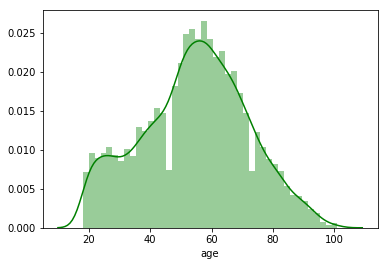

In [25]:
## It would have been easier to plot the age distribution to see the anamoly. Better late than never. So here you go!!
ax = sns.distplot(profile.age,color="g")

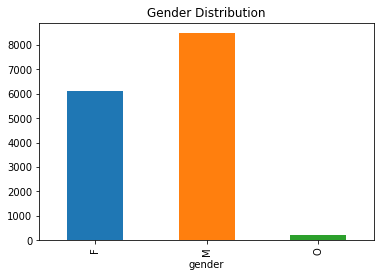

In [26]:
## Lets check the gender distribution
profile.groupby('gender')['age'].count().plot(x='gender',y='count',kind="bar",title="Gender Distribution");

In [27]:
age_df = profile.groupby('gender',as_index=False).count()

In [29]:
#Lets check the distribution of users by gender
(profile.groupby('gender').size() / profile.shape[0]) * 100

gender
F    41.342327
M    57.227656
O     1.430017
dtype: float64

**There are 212 records with gender as "O". Lets remove that.** We have to make sure records belongning to these customers are also removed from the transcript data set.

In [30]:
profile = profile[profile['gender'] != 'O']
profile = profile.reset_index(drop=True)
(profile.groupby('gender').size() / profile.shape[0]) * 100

gender
F    41.942106
M    58.057894
dtype: float64

In [31]:
# lets rename the id column to customer_id
profile.rename(columns={"id": "customer_id"}, inplace=True)
profile.head()

,age,became_member_on,gender,customer_id,income,membershipstart
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


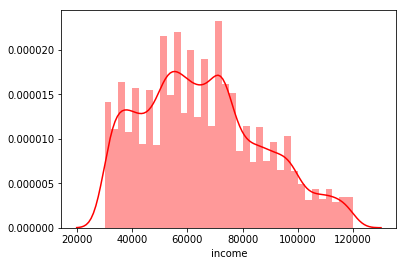

In [32]:
## Lets check the income distribution
ax = sns.distplot(profile.income,color="r")

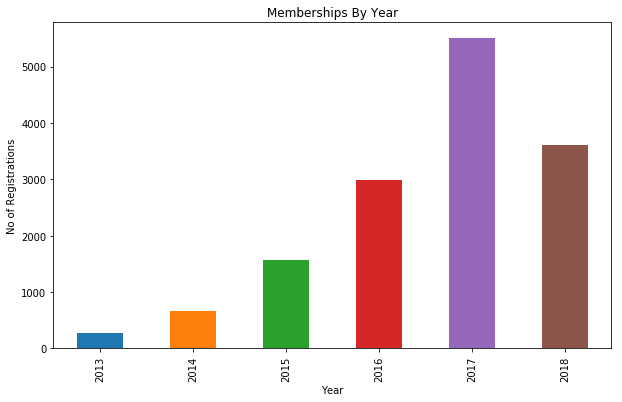

In [33]:
# Lets look at memberships by year
fig, ax = plt.subplots(figsize=(10,6))
profile.groupby('membershipstart')['age'].count().plot(ax=ax , kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("No of Registrations")
ax.set_title("Memberships By Year");

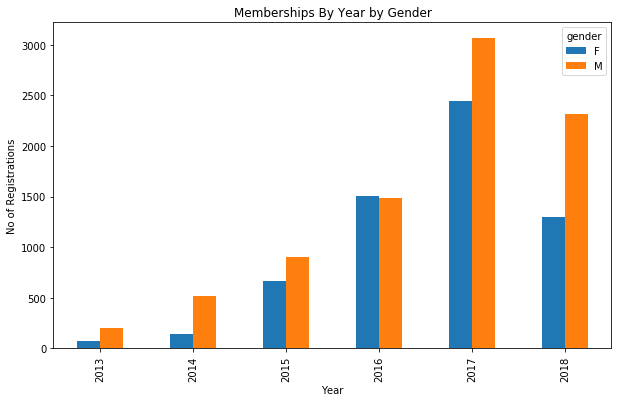

In [34]:
# Memberships by Year by Gender
fig, ax = plt.subplots(figsize=(10,6))
profile.groupby(['membershipstart','gender'])['age'].count().unstack().plot(ax=ax ,kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("No of Registrations")
ax.set_title("Memberships By Year by Gender");

In [35]:
# lets check out the customers based on gender more closely
female_customers = profile[profile.gender == 'F']
male_customers = profile[profile.gender == 'M']

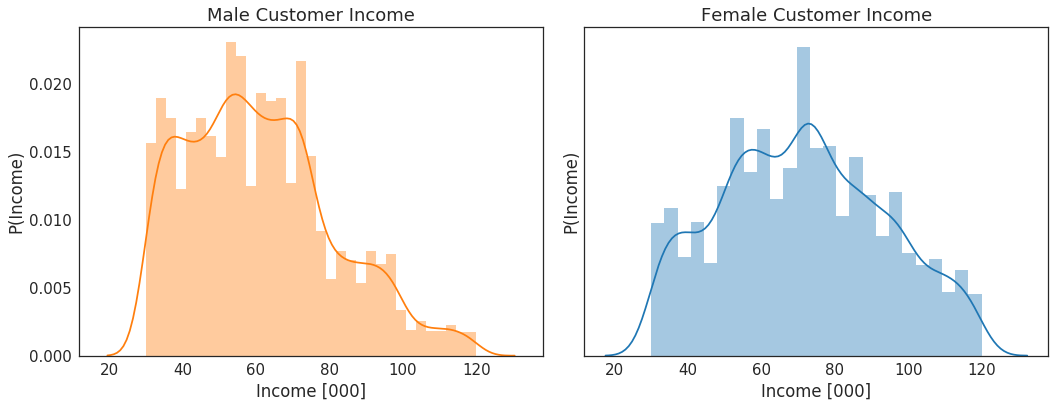

In [38]:
# lets do a combined income distribution of the two data sets so that it is easy to analyse side by side
current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(15, 6),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [000]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [000]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

#### Income Analysis Based on Gender
From the above charts it seems that the minimum and maximum income for both male and female customers is approximately the same. However, male customer income is slightly biased towards lower values compared to female customer income.

In [39]:
# One hot encode a customer's age range
min_age = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['agerange'] =   pd.cut(profile['age'],(range(min_age,max_age + 10, 10)),\
           right=False)

profile['agerange'] = profile['agerange'].astype('str')

# remove the ",", "[" and ")" from the age range values
profile.agerange = profile.agerange.str.replace(',',' -')
profile.agerange = profile.agerange.str.replace('[','')
profile.agerange = profile.agerange.str.replace(')','')

#check the data
profile.head()

,age,became_member_on,gender,customer_id,income,membershipstart,agerange
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,50 - 60
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,70 - 80
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,60 - 70
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,60 - 70
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,50 - 60


In [40]:
profile.agerange.unique().tolist()

# cleaned up data looks good

['50 - 60',
 '70 - 80',
 '60 - 70',
 '20 - 30',
 '40 - 50',
 '30 - 40',
 '90 - 100',
 '80 - 90',
 '10 - 20',
 '100 - 110']

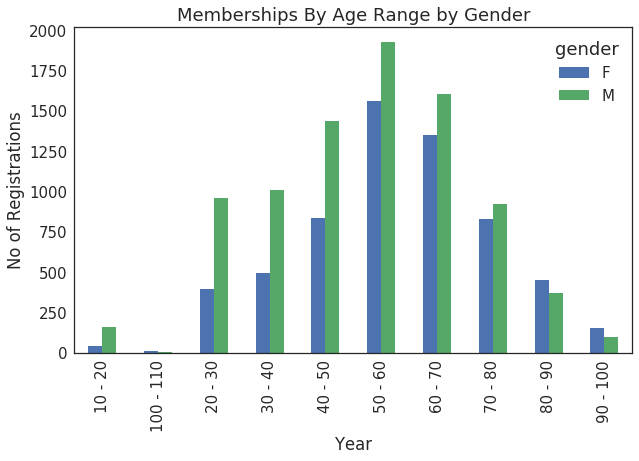

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
profile.groupby(['agerange','gender'])['age'].count().unstack().plot(ax=ax ,kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("No of Registrations")
ax.set_title("Memberships By Age Range by Gender");

**The most members are in the 50 - 60 age range, followed by 60 -70 and 40 - 50 age ranges.**

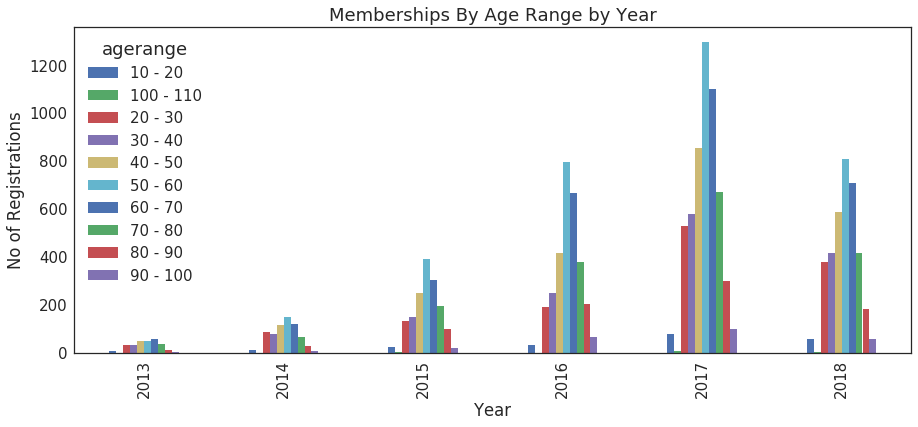

In [42]:
fig, ax = plt.subplots(figsize=(15,6))
profile.groupby(['membershipstart','agerange'])['age'].count().unstack().plot(ax=ax ,kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("No of Registrations")
ax.set_title("Memberships By Age Range by Year");

**2017 saw the most number of registrations**

In [43]:
# One Hot Encode Data
cols = ['customerid','gender','income']

#one hot encode membership start year
membershipyear_df = pd.get_dummies(profile['membershipstart'])
cols.extend(membershipyear_df.columns.values)

# One hot encode Age range values
agerange_df = pd.get_dummies(profile['agerange'])
cols.extend(agerange_df.columns.values)

# Transform a customer's gender from a character to a number
binarizerobj = LabelBinarizer()
profile['gender_value'] = binarizerobj.fit_transform(profile['gender'])

In [44]:
# Check the gender mapping
gender_map = {}
for g in binarizerobj.classes_:
    gender_map[g] = binarizerobj.transform([g])[0,0]
gender_map    

{'F': 0, 'M': 1}

In [45]:
# Appened the one hot encoded columns to the original data frame
profile = pd.concat([profile,
                     agerange_df,
                     membershipyear_df], axis=1)


In [ ]:

# Remove depcreated columns
profile = profile.drop(columns=['age',
                                'agerange',
                                'became_member_on',
                                'membershipstart'])

In [46]:
profile.head()

,age,became_member_on,gender,customer_id,income,membershipstart,agerange,gender_value,10 - 20,100 - 110,...,60 - 70,70 - 80,80 - 90,90 - 100,2013,2014,2015,2016,2017,2018
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,50 - 60,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,70 - 80,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,60 - 70,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,60 - 70,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,50 - 60,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [47]:
# lets check out some data from the transcript df
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [48]:
# Lets see event count distribution
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [49]:
print(event_counts.event.tolist())
print(event_counts['count'].tolist())

['transaction', 'offer received', 'offer viewed', 'offer completed']
[138953, 76277, 57725, 33579]


In [50]:
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


#### Transcript Data
  - Lets change the person column name to customer_id
  - change time in hours to days
  - change time column name to days

In [52]:
transcript.rename(columns={"person": "customer_id"}, inplace=True)
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [53]:
# Remove customer id's that are not in the customer profile DataFrame
select_data = transcript['customer_id'].isin(profile['customer_id'])
transcript = transcript[select_data]

percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
print("Percentage of transactions removed: %.2f %%" % percent_removed)

Percentage of transactions removed: 12.31 %


In [54]:
transcript['time'] /= 24.0
transcript.rename(columns={"time": "days"}, inplace=True)

In [55]:
transcript.head()

,event,customer_id,days,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [67]:
# Select customer offers
pattern_obj = re.compile('^offer (?:received|viewed|completed)')
h_is_offer = lambda elem: pattern_obj.match(elem) != None
is_offer = transcript['event'].apply(h_is_offer)

offers_data = transcript[is_offer].copy()
offers_data = offers_data.reset_index(drop=True)

In [68]:
cols = ['offer_id', 'customer_id', 'days']

In [69]:
offers_data['offer_id'] = offers_data['value'].apply(lambda elem: list(elem.values())[0])
offers_data.head()

,event,customer_id,days,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
2,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


#### Perform the following
  - Offer received column value to be changed to received
  - Offer viewed column to be changed to viewed

In [70]:
# Transform a column that describes a customer offer event
# https://docs.python.org/3/library/re.html
pattern_obj = re.compile('^offer ([a-z]+$)')
h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]
offers_data['event'] = offers_data['event'].apply(h_transform)

In [71]:
offers_data.groupby('event').size()

event
completed    31943
received     65585
viewed       49087
dtype: int64

In [72]:
# One hot encode customer offer events
event_df = pd.get_dummies(offers_data['event'])
event_df.head()

,completed,received,viewed
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [73]:
cols.extend(event_df.columns.values)
cols

['offer_id', 'customer_id', 'days', 'completed', 'received', 'viewed']

In [74]:
# Create a DataFrame that describes customer offer events
offers_data = pd.concat([offers_data, event_df], axis=1)
offers_data.drop(columns=['event', 'value'])
offers_data = offers_data[cols]
offers_data.head()

,offer_id,customer_id,days,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


#### Transactions performed by users
The actual transactions performed by the users are also available in the transcript df.
  - Lets create a new data frame to capture these records. 
  - We will create a new column called "amount" to capture the actual amount for each transaction from the "value" column.
  - Drop duplicate columns from the data frame (value, event)

In [75]:
# Select customer transaction events
transactions = transcript[is_offer == False]
transactions = transactions.reset_index(drop=True)
transactions.head()

,event,customer_id,days,value
0,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001}
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56}
2,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23}
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51}
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97}


In [76]:
# Transform customer transaction event values
transactions['amount'] = transactions['value'].apply(lambda elem: list(elem.values())[0])
transactions.head()

,event,customer_id,days,value,amount
0,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001},0.83
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56},34.56
2,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23},13.23
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51},19.51
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97},18.97


In [77]:
# Create a DataFrame that describes customer transactions
transactions = transactions.drop(columns=['event', 'value'])
cols = ['customer_id', 'days', 'amount']
transactions = transactions[cols]
transactions.head()

,customer_id,days,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


**Before we head further lets take a look at the data frames we have**.

  - **profile** : DataFrame that contains demographic data for each customer
  - **offer_data** : Contains offer ids and meta data (duration, difficulty, type)
  - **transactions** : DataFrame that describes customer transactions
  - **portfolio** : DataFrame that describes customer offer data

**For each customer, we will do the following:**

  - Select a customer profile
  - Select offer data for the specific customer
  - Select transactions for the specific customer
  - Identify when a customer receives, views, and completes an offer
  - Iterate through each offer that the selected customer receives
      - Get the time period (start date, end date) for the offer
      - select customer transactions that fall within the valid offer time window
      - Identify when a customer completes an offer
      - Identify when a customer views an offer
      - Determine whether the current offer was successful. For an offer to be successful a customer has to view and complete it
      - Select customer transactions that occurred within the current offer valid time period
      
Once all customer transactions have been evaluated, create a new pandas DataFrame.

In [104]:
def combine_records(customer_id, portfolio, profile, offer_data, transactions):
    """ 
    Creates a list of dictionaries that describes the effectiveness of
    offers to a specific customer
    INPUT:
        customer_id: Customer Id
        portfolio: DataFrame containing offer ids and meta data about each offer (duration, type, etc.)
        offer_data: DataFrame that describes customer offer data
        transactions: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: customer information, offer infomration and whether the offer was successful
    """
    
    # Select a customer's profile from the profile data frame
    customer = profile[profile['customer_id'] == customer_id]

    # Select offer data for a specific customer
    valid_offer_data = offer_data['customer_id'] == customer_id
    customer_offers = offer_data[valid_offer_data]
    customer_offers = customer_offers.drop(columns='customer_id')
    customer_offers = customer_offers.reset_index(drop=True)

    # Select transactions for a specific customer
    valid_transaction = transactions['customer_id'] == customer_id
    customer_transactions = transactions[valid_transaction]
    customer_transactions = customer_transactions.drop(columns='customer_id')
    customer_transactions = customer_transactions.reset_index(drop=True)    

    # select received offer data
    # drop event type columns
    received = customer_offers[customer_offers['received'] == 1]
    received = received.drop(columns=['completed','received','viewed'])
    received = received.reset_index(drop=True)

    # select viewed offer data
    # drop event type columns
    viewed = customer_offers[customer_offers['viewed'] == 1]
    viewed = viewed.drop(columns=['completed','received','viewed'])
    viewed = viewed.reset_index(drop=True)

    # select completed offer data
    # drop event type columns
    completed = customer_offers[customer_offers['completed'] == 1]
    completed = completed.drop(columns=['completed','received','viewed'])
    completed = completed.reset_index(drop=True)    
    
    #Process each offer data
    rows = []
    for idx in range(received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = received.iloc[idx]['offer_id']

        # Get the current offer row and the days
        cur_offer = portfolio.loc[portfolio['offer_id'] == cur_offer_id]
        durationdays = cur_offer['duration'].values[0]

        # Get the time period when an offer is valid, (start time and end time)
        cur_offer_startime = received.iloc[idx]['days']
        cur_offer_endtime = received.iloc[idx]['days'] + durationdays

        # Initialize an array to hold customer transcations that fall within the valid offer time period
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.logical_and.html
        valid_transaction = np.logical_and(customer_transactions['days'] >= \
                           cur_offer_startime,
                           customer_transactions['days'] <=
                           cur_offer_endtime)

        # Initialize a array with information about when a customer completes an offer
        select_offer_completed = np.logical_and(completed['days'] >= cur_offer_startime, \
                           completed['days'] <= cur_offer_endtime)

        # Initialize a array with information about when a customer views an offer
        select_offer_viewed = np.logical_and(viewed['days'] >= cur_offer_startime, \
                           viewed['days'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful = select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer's valid time period
        cur_offer_transactions = customer_transactions[valid_transaction]

        # Initialize a dictionary with the current customer offer
        cur_row = {'offer_id': cur_offer_id,
                   'customer_id': customer_id,
                   'time': cur_offer_startime,
                   'offer_successful': int(cur_offer_successful),
                   'total_amount': cur_offer_transactions['amount'].sum()}
        
        cur_row.update(cur_offer.iloc[0,0:].to_dict())
        cur_row.update(customer.iloc[0,0:].to_dict())
        rows.append(cur_row)
        
    return rows    

In [79]:
clean_data = []
customerid_list = offer_data['customer_id'].unique()
#customerid_list

In [105]:
# lets look at one record to see how it comes out
data = combine_records(customerid_list[6],portfolio,profile,offers_data,transactions)
clean_df = pd.DataFrame(data)
clean_df[['age','offer_id','customer_id','total_amount','agerange','gender','offer_successful','duration','time','offer_type','income']]

,age,offer_id,customer_id,total_amount,agerange,gender,offer_successful,duration,time,offer_type,income
0,64,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,0.00,60 - 70,M,0,7,0.0,bogo,100000.0
1,64,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,109.28,60 - 70,M,1,10,7.0,discount,100000.0
2,64,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,61.05,60 - 70,M,1,10,14.0,discount,100000.0
3,64,3f207df678b143eea3cee63160fa8bed,4b0da7e80e5945209a1fdddfe813dbe0,30.00,60 - 70,M,1,4,17.0,informational,100000.0
4,64,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,31.05,60 - 70,M,1,7,21.0,bogo,100000.0


In [106]:
clean_data = []
customerid_list = offer_data['customer_id'].unique()

for idx in range(len(customerid_list)):
    clean_data.extend(combine_records(customerid_list[idx],portfolio,profile,offers_data,transactions))
    
clean_data = pd.DataFrame(clean_data)

clean_data = clean_data.sort_values('time')
clean_data.reset_index(drop=True)

clean_data.head()

,10 - 20,100 - 110,20 - 30,30 - 40,40 - 50,50 - 60,60 - 70,70 - 80,80 - 90,90 - 100,...,social,time,total_amount,web,2013,2014,2015,2016,2017,2018
0,0,0,0,0,0,0,0,1,0,0,...,0,0.0,37.67,1,0,0,0,0,1,0
11262,0,0,0,0,0,1,0,0,0,0,...,1,0.0,48.31,1,0,0,1,0,0,0
35019,0,0,0,0,1,0,0,0,0,0,...,1,0.0,23.43,0,0,0,0,0,1,0
35016,0,0,0,0,0,0,0,1,0,0,...,0,0.0,52.24,1,0,0,0,1,0,0
11266,0,0,0,1,0,0,0,0,0,0,...,1,0.0,5.12,1,0,0,0,0,0,1


In [107]:
clean_data.to_csv('cleaned_data.csv',index=False)

**Now that we have the combined data frame, lets do some more EDA**

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.columns

Index(['10 - 20', '100 - 110', '20 - 30', '30 - 40', '40 - 50', '50 - 60',
       '60 - 70', '70 - 80', '80 - 90', '90 - 100', 'age', 'agerange',
       'became_member_on', 'bogo', 'channels', 'customer_id', 'difficulty',
       'discount', 'duration', 'email', 'gender', 'gender_value', 'income',
       'informational', 'membershipstart', 'mobile', 'offer_id',
       'offer_successful', 'offer_type', 'reward', 'social', 'time',
       'total_amount', 'web', '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [4]:
df1 = df.copy().drop(columns=['agerange','became_member_on', 'bogo', 'channels', 'customer_id','gender','membershipstart',
                             'offer_id','offer_successful', 'offer_type','time','total_amount'])

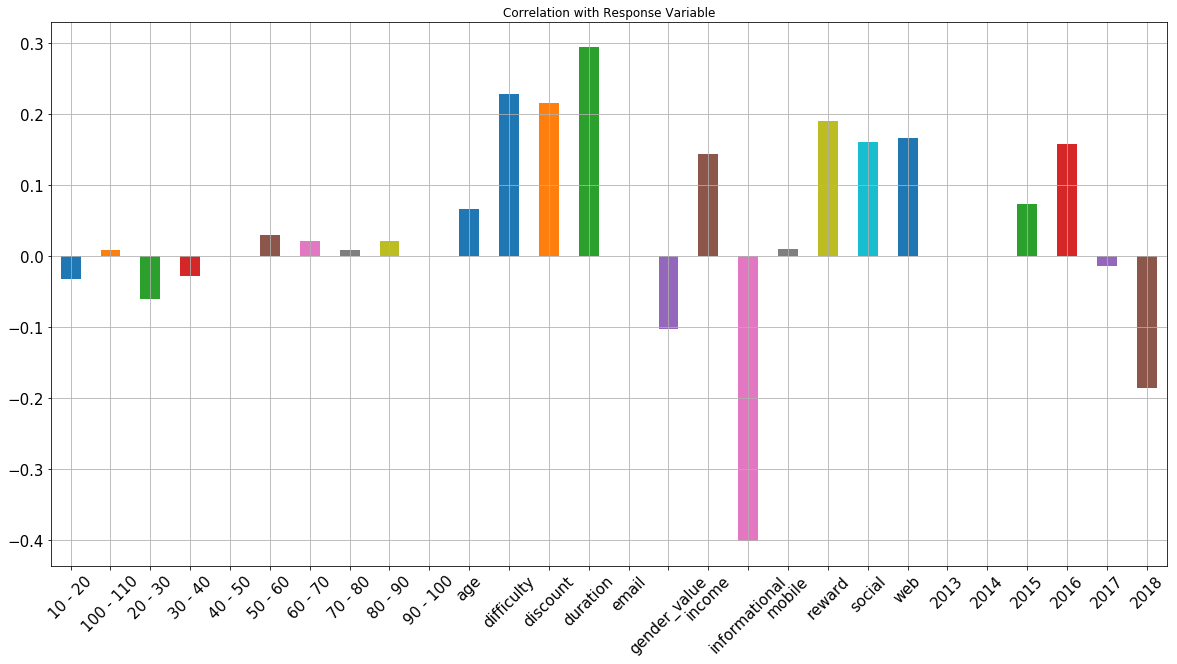

In [7]:
# lets plot the correlation of different numerical features to the targe (offer_successful)
df1.corrwith(df.offer_successful).plot.bar(figsize=(20,10),
                        title='Correlation with Response Variable',
                        fontsize=15, rot=45, grid=True);

#### From the above chart we find that:
  - difficulty, duration, discount, reard, income has positive corelation to the target
  
lets also plot histogram for some of the feature columns. 
I am gonna include difficulty, duration, discount, reard, income, age, gender_value for analysis

In [5]:
# create a new data frame to plot the histograms
df2 = df1.copy().drop(columns=['10 - 20', '100 - 110', '20 - 30', '30 - 40', '40 - 50', '50 - 60',
       '60 - 70', '70 - 80', '80 - 90', '90 - 100','2013','2014','2015','2016','2017','2018','web',
                               'social','mobile','email','informational'])


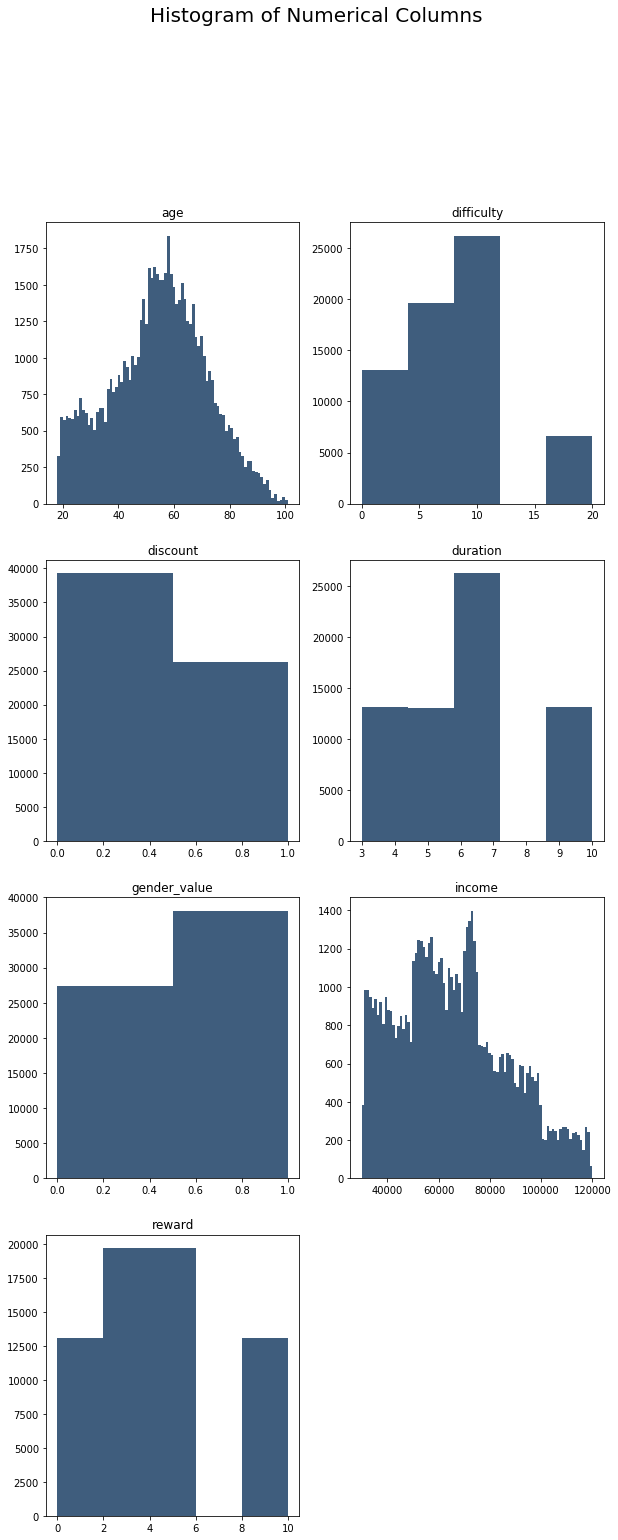

In [14]:
# lets also plot histogram for some of the feature columns.
fig=plt.figure(figsize=(10, 30), facecolor='w', edgecolor='k')
fig.suptitle("Histogram of Numerical Columns", fontsize=20)
for i in range(1, df2.shape[1] + 1):
    plt.subplot(5, 2, i)
    f = plt.gca()
    f.set_title(df2.columns.values[i - 1])
    
    # get the binsize
    vals = np.size(df2.iloc[:,i - 1].unique())
    plt.hist(df2.iloc[:, i -1 ], bins=vals, color='#3F5D7D')

**Some of the inferences from the histogram**
  - seems to be more male customers compared to female customers
  - rewards between 2 - 7 seems to be more popular
  - offers with duration of 7 days seems to be more
  - offers with diffficulty 5 - 10 seems to be more
  - there is a spike in age around 60, otherwise it is evenly distributed
  
**Now lets look at successful offers (where offer_successful = 1)**

In [6]:
# create a new data frame with successful records
df_success = df[ df.offer_successful == 1 ]
df_success.shape

(30856, 40)

In [16]:
# get the count of unique customers to compare the male vs female ratio
custs_df = df [['customer_id','gender']]
unique_custs = custs_df.drop_duplicates()
unique_custs.groupby('gender')['customer_id'].count()/unique_custs.shape[0]*100

gender
F    41.92908
M    58.07092
Name: customer_id, dtype: float64

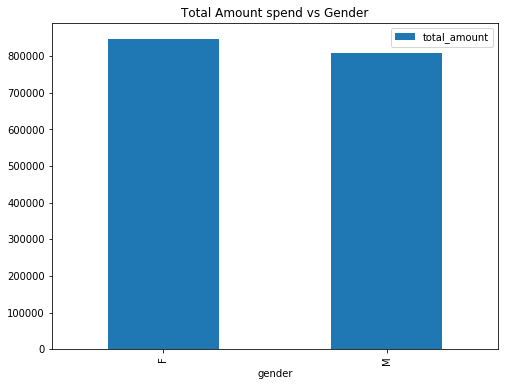

In [17]:
# lets plot the total amount spend by each gender
df_success.groupby(['gender'],as_index=False)['total_amount'].sum().plot(x="gender", y=["total_amount"], 
                    kind="bar", figsize=(8,6), 
                    title="Total Amount spend vs Gender");

**Nice observation :**
  - 42% female customers
  - 58% male customers
  - The total amount spend by female customers are more than male customers

Does that women they drink more coffee / tea? Not necessarily. Because starbucks has other offerings as well.
So they could be spending more money on those. ***However it seems on average women spend more money at Starbucks.***

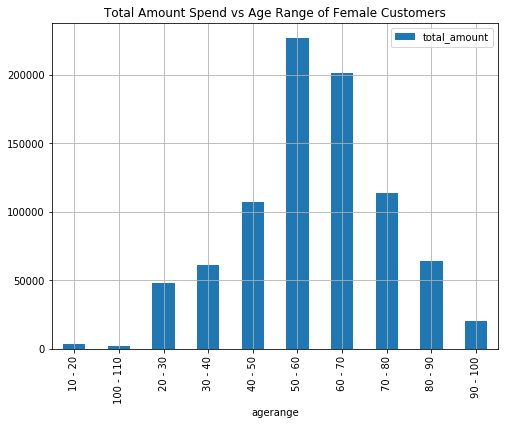

In [18]:
# Lets look at the various age group for the female customers and how much they spend
femme_df = df_success[ df_success.gender == 'F']
femme_total_df = femme_df.groupby(['agerange'],as_index=False)['total_amount'].sum()
femme_total_df.plot(x="agerange", y=["total_amount"], 
                    kind="bar", figsize=(8,6), 
                    title="Total Amount Spend vs Age Range of Female Customers", 
                    grid=True);

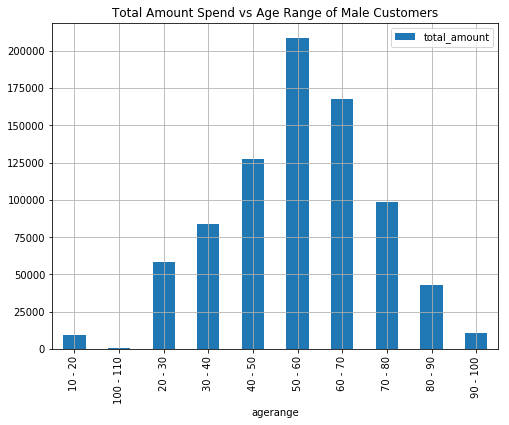

In [19]:
# Lets look at the various age group for the male customers and how much they spend
homme_df = df_success[ df_success.gender == 'M']
homme_total_df = homme_df.groupby(['agerange'],as_index=False)['total_amount'].sum()
homme_total_df.plot(x="agerange", y=["total_amount"], 
                    kind="bar", figsize=(8,6), 
                    title="Total Amount Spend vs Age Range of Male Customers", 
                    grid=True);

**Seems folks belonging to 50 - 60 age range in both groups (female , male) spend more money. 40 - 50 and 60 - 70 age groups also spend more money compared to other age groups**

***If you are wondering what femme and homme is, those are french equivalent words for woman and man.***

#### Duration, Discount and Reward
Lets look the duration, discount and reward and how many offers were completed for each


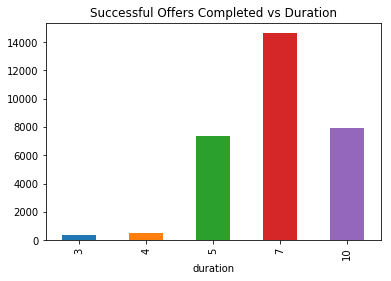

In [20]:
# group by duration and plot
df_success.groupby('duration')['time'].count().plot(x='duration',y='count',
                                                    kind="bar",title="Successful Offers Completed vs Duration");

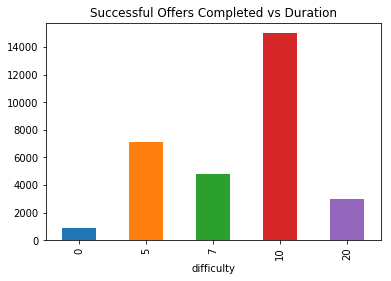

In [21]:
# group by difficulty and plot
df_success.groupby('difficulty')['time'].count().plot(x='difficulty',y='count',
                                                    kind="bar",title="Successful Offers Completed vs Duration");

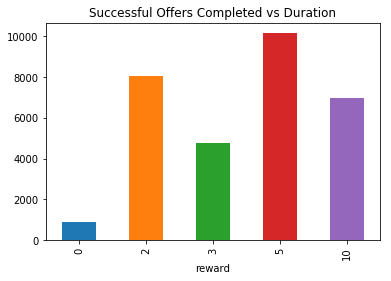

In [22]:
# group by reward and plot
df_success.groupby('reward')['time'].count().plot(x='reward',y='count',
                                                    kind="bar",title="Successful Offers Completed vs Duration");

**Duration and Successful Offers :**
  - Offers with duration of 5, 7 and 10 has more successful offers
  - the highest being offers with duration of 7 days

**Difficulty and Successful Offers :**
  - Offers with duration of 5, 7 and 10 has more successful offers
  - the highest being offers with difficulty of 10 days
  - this could be becuase more the difficulty more the duration and more the reward

**Reward and Successful Offers :**
  - Offers with reward of 2, 5 and 10 has more successful offers
  - the highest being offers with a reward of 5


### Train, Test and Evaluate Model
We need to 
  - drop the below columns
    - customer_id, offer_id, became_member_on, gender, age, agerange, channels, offert_type, time
    membershipstart, total_amount
  - perform a min max feature scaling on the below columns:
    - difficulty, duration, reward, income
  - create train and test data set
  - train the model
  - evauluate the results
  - use grid search to find the best parameters
  - improve the model

In [3]:
dataset = df.copy().drop( columns = ['customer_id','offer_id','became_member_on','gender',\
                                     'channels','age','agerange','offer_type','membershipstart','total_amount','time'])
dataset.columns

Index(['10 - 20', '100 - 110', '20 - 30', '30 - 40', '40 - 50', '50 - 60',
       '60 - 70', '70 - 80', '80 - 90', '90 - 100', 'bogo', 'difficulty',
       'discount', 'duration', 'email', 'gender_value', 'income',
       'informational', 'mobile', 'offer_successful', 'reward', 'social',
       'web', '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()
dataset[['difficulty', 'duration', 'reward', 'income']] = \
                        scaler.fit_transform(dataset[['difficulty', 'duration', 'reward', 'income']])

In [5]:
# Lets check out the data and it looks good.
dataset[['difficulty', 'duration', 'reward', 'income']].head()

,difficulty,duration,reward,income
0,0.25,0.571429,0.5,0.777778
1,0.50,0.285714,1.0,0.100000
2,0.00,0.000000,0.0,0.244444
3,0.25,0.571429,0.5,0.977778
4,0.50,1.000000,0.2,0.155556


In [6]:
# lets check out the columns
dataset.columns

Index(['10 - 20', '100 - 110', '20 - 30', '30 - 40', '40 - 50', '50 - 60',
       '60 - 70', '70 - 80', '80 - 90', '90 - 100', 'bogo', 'difficulty',
       'discount', 'duration', 'email', 'gender_value', 'income',
       'informational', 'mobile', 'offer_successful', 'reward', 'social',
       'web', '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [7]:
# Lets create test and train data
X = dataset.copy().drop(columns=['offer_successful'])
y = dataset['offer_successful']

In [14]:
X.head()

,10 - 20,100 - 110,20 - 30,30 - 40,40 - 50,50 - 60,60 - 70,70 - 80,80 - 90,90 - 100,...,mobile,reward,social,web,2013,2014,2015,2016,2017,2018
0,0,0,0,0,0,0,0,1,0,0,...,1,0.5,0,1,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,1,1.0,1,1,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0.0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0.5,0,1,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0.2,1,1,0,0,0,0,0,1


In [15]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: offer_successful, dtype: int64

#### Split the data into training and testing data

In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
random_state = 123456789

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X,
                            y,
                            test_size=0.2,
                            random_state=random_state)


In [17]:
print("X_Train : ",X_train.shape)
print("X_Test : ",X_test.shape)
print("y_Train : ",y_train.shape)
print("y_Test : ",y_test.shape)

X_Train :  (52468, 28)
X_Test :  (13117, 28)
y_Train :  (52468,)
y_Test :  (13117,)


### SVM Model

[sklearn SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
[Support Vector Machine](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

Common Parameters that can be changed to tune performance of the model
  - C (the higher the C value the more time it takes to train the model)
  - gamma (the higher the gamma value the more time it takes to train the model)
  - kernel (‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable). default is 'rbf'

In [9]:
# Train using default parameters (C, gamma and use the default kernel "rbf")
svc_model = SVC(random_state=random_state)
svc_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123456789, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
#predict the accuracy
y_pred = svc_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.722421285355


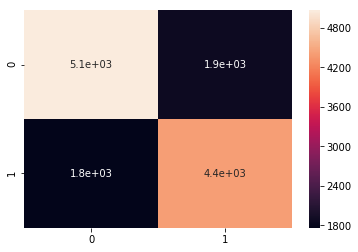

In [11]:
cm = confusion_matrix( y_test, y_pred)
sns.heatmap(cm, annot=True);

In [12]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.74      0.73      0.74      6937
          1       0.70      0.71      0.71      6180

avg / total       0.72      0.72      0.72     13117



Even for such a small data set SVM model took lot of time to train the model. We could try tuning the C and gamma variables and try to fine tune the model. The higher the C and gamma values, the more it is going to take to train the model.

So let's try out few other algorithms like Logistic Regression and Random Forest Classifier.

#### Logistic Regression model

[sklearn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

We will try the following parameters to tune the model:
  - penalty: Used to specify the norm used in the penalization.
  - solver: We will choose 'liblinear' as the sovler since this is not a big data set
  - C: Inverse of regularization strength; must be a positive float.

  - Perform random search of model hyperparameter space
    - Accuracy :  0.718
    - F1-score :  0.712

In [36]:
lr_model = LogisticRegression(random_state=random_state,
                            solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123456789, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
#predict the accuracy
y_lr_pred = lr_model.predict(X_test)
print(accuracy_score(y_test,y_lr_pred))

0.725547000076


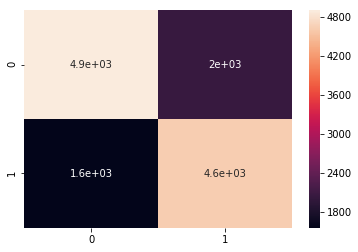

In [38]:
cm = confusion_matrix( y_test, y_lr_pred)
sns.heatmap(cm, annot=True);

In [39]:
print(classification_report(y_test,y_lr_pred))

             precision    recall  f1-score   support

          0       0.76      0.71      0.73      6937
          1       0.69      0.75      0.72      6180

avg / total       0.73      0.73      0.73     13117



#### Tune Parameters to improve model performance
  - We will use Grid Search to find the relatiely best values for the different parameters
  - We will use the following
    - penalty
    - solver
    - C
    - max_iter

In [20]:
lr_param_grid = {'penalty':['l1','l2'] ,'C':[0.1, 1, 10,100], 'solver':['liblinear'],'max_iter':[100,200,300] }
lr_grid = GridSearchCV(LogisticRegression(random_state= random_state), lr_param_grid, refit = True, verbose = 4)

In [21]:
lr_grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=0.1, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.717095483133219, total=   0.8s
[CV] C=0.1, max_iter=100, penalty=l1, solver=liblinear ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.7192521013208303, total=   2.3s
[CV] C=0.1, max_iter=100, penalty=l1, solver=liblinear ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.7275430270455715, total=   1.4s
[CV] C=0.1, max_iter=100, penalty=l2, solver=liblinear ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s


[CV]  C=0.1, max_iter=100, penalty=l2, solver=liblinear, score=0.7167524299599771, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l2, solver=liblinear, score=0.7183944193493053, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l2, solver=liblinear, score=0.7277717422379781, total=   0.3s
[CV] C=0.1, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.717095483133219, total=   0.8s
[CV] C=0.1, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.7192521013208303, total=   1.8s
[CV] C=0.1, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.7275430270455715, total=   1.4s
[CV] C=0.1, max_iter=200, penalty=l2, solver=liblinear .........

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123456789, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [22]:
lr_grid.best_params_

{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

0.725242052299


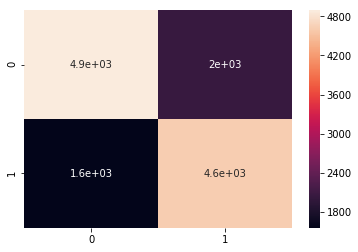

In [23]:
lr_opt_y_pred = lr_grid.predict(X_test)

print(accuracy_score(y_test,lr_opt_y_pred))

lr_cm1 = confusion_matrix( y_test, lr_opt_y_pred)
sns.heatmap(lr_cm1, annot=True);

In [24]:
print(classification_report(y_test,lr_opt_y_pred))

             precision    recall  f1-score   support

          0       0.76      0.70      0.73      6937
          1       0.69      0.75      0.72      6180

avg / total       0.73      0.73      0.73     13117



**Even after tuning the selected parameters, we dont see much of improvement in the precision.**. There are other parameters that we can try.

#### Construct Random Forest Model

[sklearn Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[Random Forest Blog](https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1)

We will try the below parameters:
  - n_estimators : The number of trees in the forest.
  - criterion : The function to measure the quality of a split.
  - min_samples_split : The minimum number of samples required to split an internal node
  - min_samples_leaf : The minimum number of samples required to be at a leaf node. 
 
  - Perform random search of model hyperparameter space
    - Accuracy : 0.742
    - F1-score : 0.735

In [25]:
rf_model = RandomForestClassifier(random_state=random_state)

In [26]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123456789, verbose=0,
            warm_start=False)

In [27]:
y_rf_pred = rf_model.predict(X_test)
print(accuracy_score(y_test,y_rf_pred))

0.692460166197


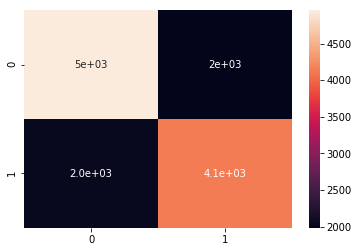

In [28]:
rf_cm = confusion_matrix( y_test, y_rf_pred)
sns.heatmap(rf_cm, annot=True);

In [29]:
print(classification_report(y_test,y_rf_pred))

             precision    recall  f1-score   support

          0       0.71      0.71      0.71      6937
          1       0.68      0.67      0.67      6180

avg / total       0.69      0.69      0.69     13117



In [30]:
rf_clf = RandomForestClassifier(random_state=random_state)

# Number of trees in random forest
n_estimators = [100, 200, 300]

# Maximum number of levels in tree
max_depth = [int(x) for x in range(5, 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]

# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

randf = GridSearchCV(estimator = rf_clf,
                               param_grid  = random_grid,
                               cv = 3,
                               verbose=2,
                               n_jobs = 3)

randf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   6.6s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   6.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   6.7s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=  12.4s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=300 
[CV]  max_depth=5, min_samples

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.8min


[CV]  max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=300, total=  18.8s
[CV] max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100, total=   6.3s
[CV] max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100, total=   6.2s
[CV] max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100, total=   6.3s
[CV] max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=  12.3s
[CV] max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=  12.3s
[CV] max_depth=5, min_samples_leaf=4, min_samples_split=4, n_es

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 14.0min


[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=  16.3s
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=  16.2s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=300 
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=  16.5s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=300, total=  24.5s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=300, total=  24.5s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=300, total=  24.0s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_es

[Parallel(n_jobs=3)]: Done 324 out of 324 | elapsed: 34.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123456789, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [100, 200, 300], 'max_depth': [5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [31]:
y_rf_opt_pred = randf.best_estimator_.predict(X_test)
print(accuracy_score(y_test,y_rf_opt_pred))

0.735838987573


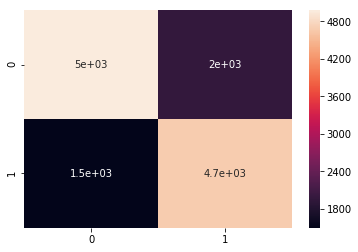

In [32]:
rf_cm1 = confusion_matrix( y_test, y_rf_opt_pred)
sns.heatmap(rf_cm1, annot=True);

In [33]:
print(classification_report(y_test, y_rf_opt_pred))

             precision    recall  f1-score   support

          0       0.77      0.72      0.74      6937
          1       0.70      0.76      0.73      6180

avg / total       0.74      0.74      0.74     13117



#### Random Forest Classifier
  - We use grid search to find the best parameter values
  - there was 5% improvement in the precision, which is good
  - GridSearch took more time to evaluate the optimal parameter combinations
  - As an improvement we could user RandomSearchCV instead of GridSearchCV
  
Random Forest Classifier performs feature importance and selection internally while constructing the model. The model can also report on the variable importance determined during the model preparation process. Now lets check out the Feature importance. 

In [36]:
variable_names = X_train.columns
variable_names

Index(['10 - 20', '100 - 110', '20 - 30', '30 - 40', '40 - 50', '50 - 60',
       '60 - 70', '70 - 80', '80 - 90', '90 - 100', 'bogo', 'difficulty',
       'discount', 'duration', 'email', 'gender_value', 'income',
       'informational', 'mobile', 'reward', 'social', 'web', '2013', '2014',
       '2015', '2016', '2017', '2018'],
      dtype='object')

#### Plot Estimated Feature Importance

The top features for this problem are:
  - Offer difficulty (how much money a customer must spend to complete an offer. this is dependent on reward and duration as well. Even if the difficulty is more, if the offer is valid for a longer time period and if the reward is higher, there is a higher chance that offer will be completed by customers)
  - Offer reward (more the reward the better the probability of customer completing an offer)
  - Offer duration (more the duration the better the probability of customer completing an offer
  - Customer income 
  - 2018 (Year when the user created the account)
  - social (whether the offers area available through social media. this make sense as more and more people are using social media like instagra, twitter, FB, Snapchat etc)
  - informational (the offer was informational message. This could mean that if it is informational people generally may not complete the offer. and could be a major feature in identifying what type of offer is more effective)
  
**I am surprised that bogo and discount are not in the top 5 features.**

Text(0.5,1,'Random Forest Estimated Feature Importance')

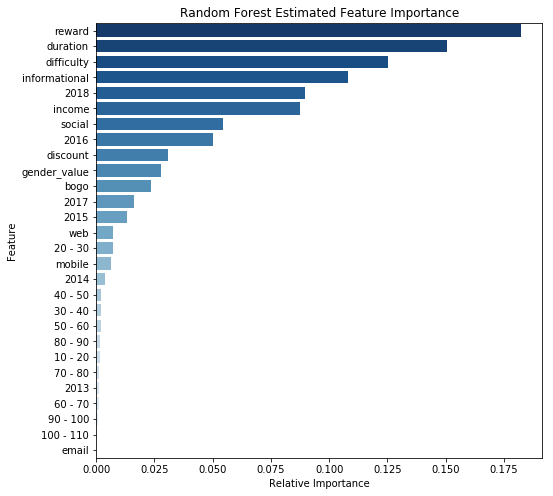

In [37]:
relative_importance = randf.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [38]:
feature_importance.head(n=10)

,feature,relativeimportance
0,reward,0.182462
1,duration,0.150666
2,difficulty,0.125439
3,informational,0.108255
4,2018,0.089817
5,income,0.087475
6,social,0.054444
7,2016,0.050291
8,discount,0.030711
9,gender_value,0.027704


### Conclusion

The problem that I chose to solve was to build a model that, given a set of features of predicts the chances of an offer being successful or not. My strategy for solving this problem has four steps. 
  - First i cleaned up the data sets
  - Second, I combined offer portfolio, customer profile, and transaction data into one data frame and this was the fun part. 
  - In the next step I some more analysis of the dataset to check the following:
    - Correlation of Income to offer being successful
    - Who spens more money (Women or Men)
    - How reward affects the success of the offer
    - How difficutly affects the success of the offer
    - How duration affects the success of the offer
  - In the last step, I created 3 models and evaluated the results
    - SVM
    - Logistic Regression (I tried it with default parameter values and then used Grid Search to fine tune the parameters)
    - Ramdon Forest Classifer (I tried it with default parameter values and then used Grid Search to fine tune the parameters)
    
I compared the performance of logistic regression, svm and random forest models. This analysis suggests that a random forest model has the best training data accuracy and F1-score. The same is the case for test data, random forest seems to do better.

Feature importance refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training. The below are the top features:

  - Offer difficulty (how much money a customer must spend to complete an offer)
  - Offer reward
  - Offer duration
  - Customer income
  - 2018 (Year when the user created the account)
  - social (whether the offers are available through social media) 
  - informational

##### Improvements
  - We can refine random forest model hyperparameters using more parameters. The new model parameters may yield us better results.
  - we could also try other models and then compare the accuracy of all the models to find the best one.

For this project the most important point was the data cleansing activities and combining the data sets into one data set. Feature engineering is very important and here is a [great article on the same](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/).